Using cuda:0 device
Starting training...
Epoch 1/27, Training Loss: 0.9591480936759558, Validation Loss: 0.8454312223654527, Training Accuracy: 0.6326838087585376, Validation Accuracy: 0.6650602409638554
Epoch 2/27, Training Loss: 0.7691764888855127, Validation Loss: 1.0392297338216732, Training Accuracy: 0.6935516271595018, Validation Accuracy: 0.5586345381526104
Epoch 3/27, Training Loss: 0.699658721112288, Validation Loss: 0.9659299254417419, Training Accuracy: 0.7146444355162715, Validation Accuracy: 0.6566265060240963
Epoch 4/27, Training Loss: 0.6350905029819562, Validation Loss: 1.0711962993328388, Training Accuracy: 0.7479911611088791, Validation Accuracy: 0.5943775100401606
Epoch 5/27, Training Loss: 0.5548367133507361, Validation Loss: 0.750289532618645, Training Accuracy: 0.7821414222579349, Validation Accuracy: 0.7160642570281125
Epoch 6/27, Training Loss: 0.4921996624041826, Validation Loss: 1.0603776833949945, Training Accuracy: 0.8108678184009642, Validation Accuracy: 0.

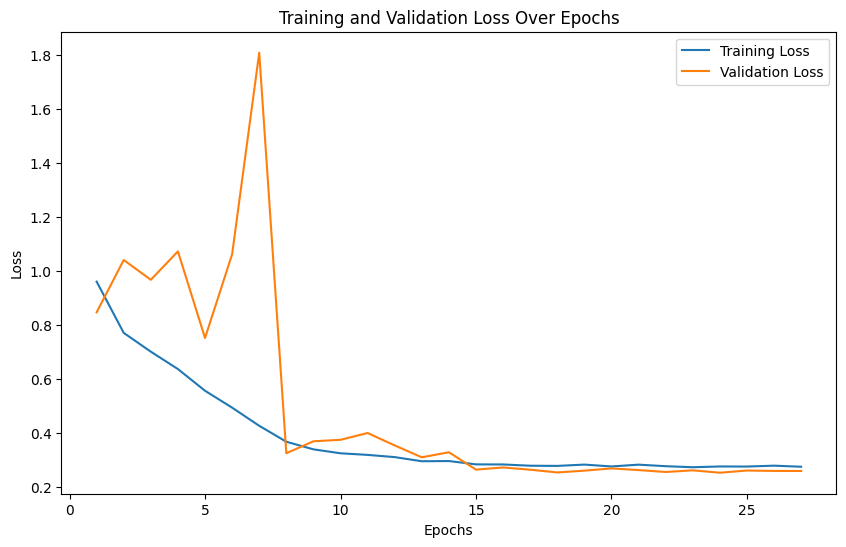

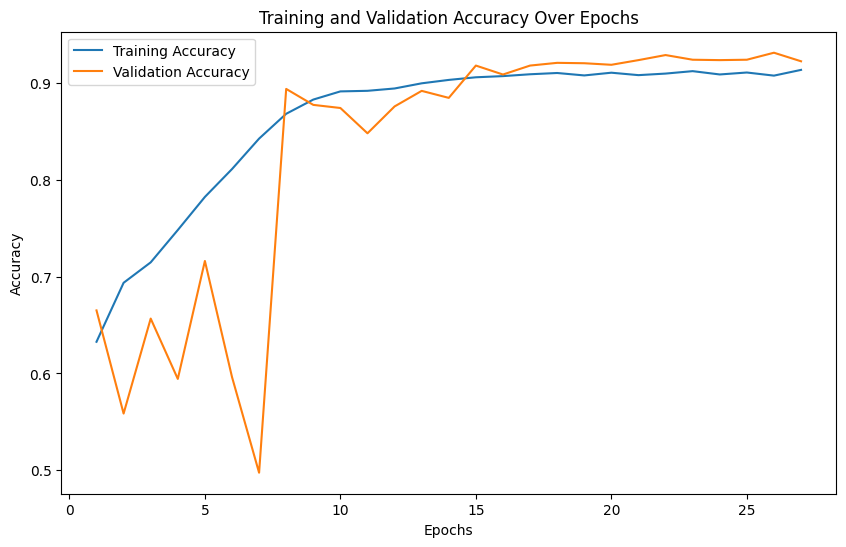

Evaluating model...
Accuracy: 0.921
Precision: 0.921
Recall: 0.921
F1 Score: 0.920
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.91      0.97      0.94       749
      Normal       0.95      0.96      0.95      1017
       Stone       0.91      0.73      0.81       267
       Tumor       0.88      0.87      0.88       457

    accuracy                           0.92      2490
   macro avg       0.91      0.88      0.89      2490
weighted avg       0.92      0.92      0.92      2490



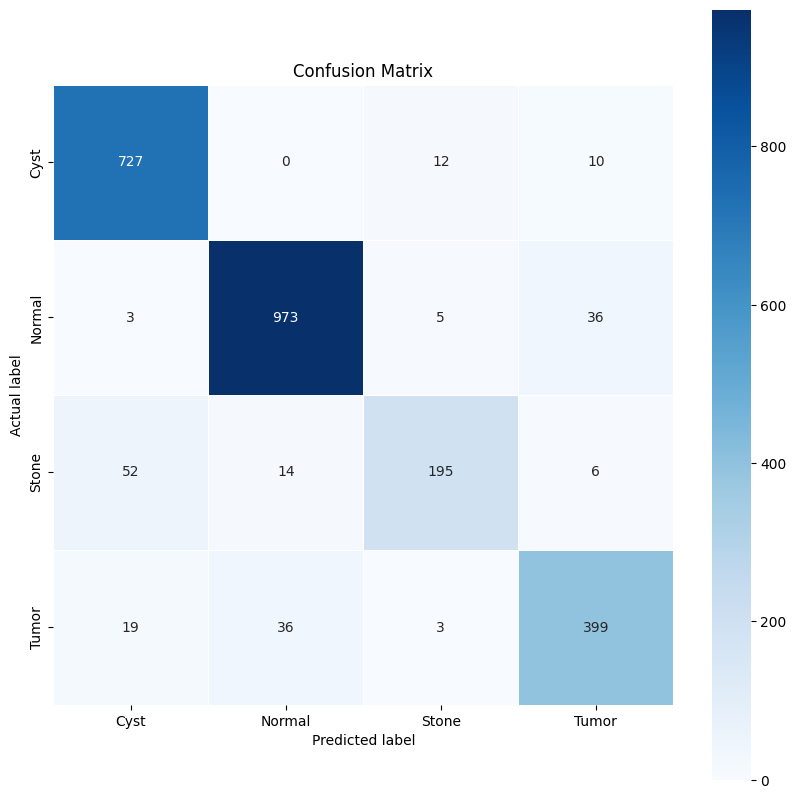

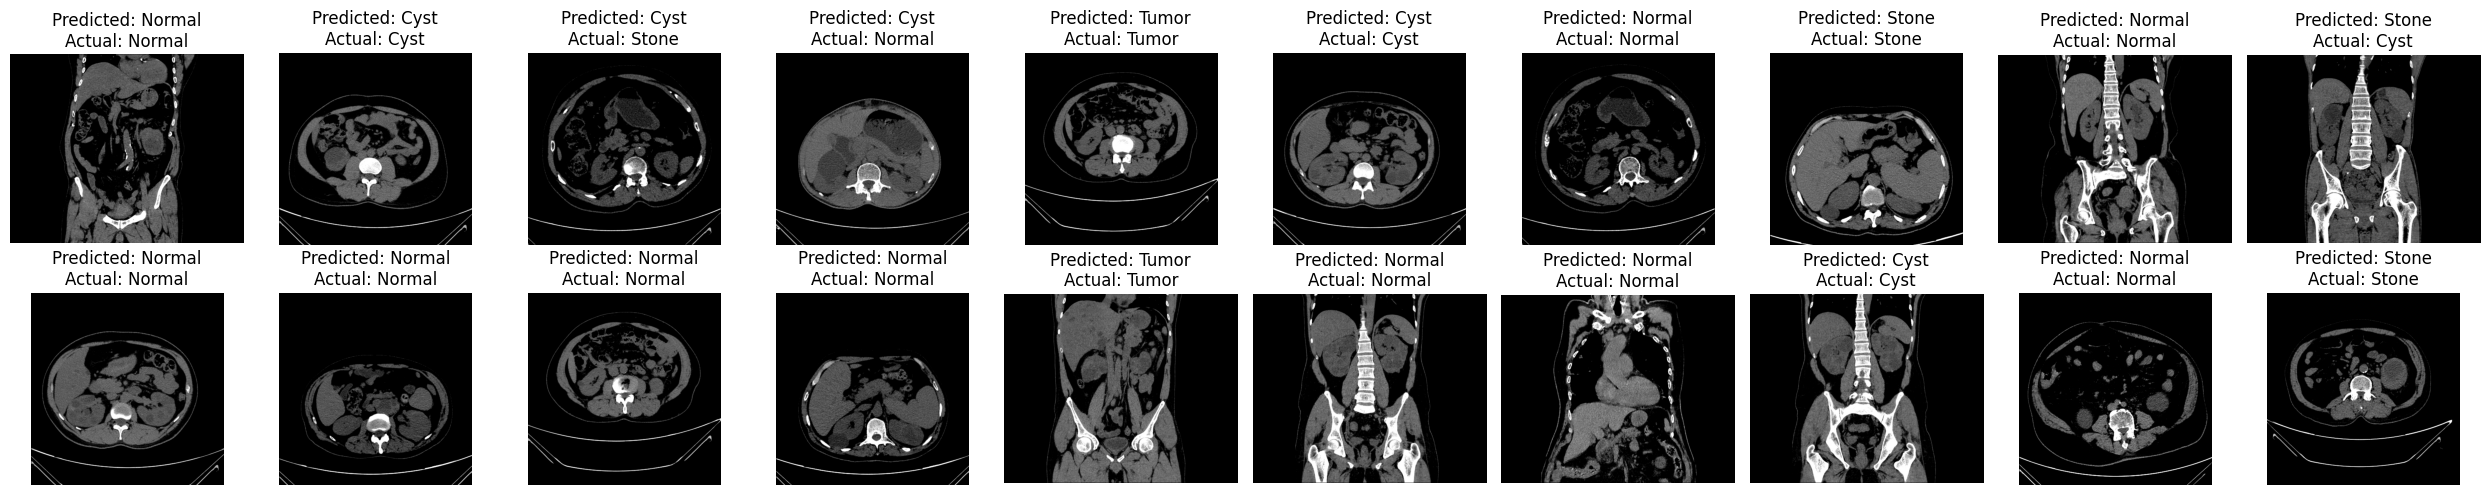

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import time
from PIL import Image
import random
from torchvision import models

# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Enhanced Transformations with more augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
data_dir = "C:/Users/SirM/Downloads/archive (1)/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Calculate split sizes for 80-20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Define the CNN Model
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet10(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet10, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet10(num_classes=1000):
    return ResNet10(BasicBlock, [1, 1, 1, 1], num_classes)

num_classes = len(full_dataset.classes)
model = resnet10(num_classes=num_classes).to(device)

# Loss Function and Optimizer with L2 Regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Enhanced training loop with validation loss and accuracy tracking
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
start_time = time.time()
num_epochs = 27

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_loss = train_running_loss / len(train_loader)
    val_loss = val_running_loss / len(val_loader)
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total

    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}")

    # Learning Rate Scheduler Step
    scheduler.step()

end_time = time.time()
print(f"Finished Training in {end_time - start_time:.2f} seconds")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
print("Evaluating model...")
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Accuracy: {accuracy:.3f}")
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


def display_image_full_res(image_path, ax, pred_label, true_label):
    """Displays a full-resolution image with predicted and actual labels."""
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f'Predicted: {pred_label}\nActual: {true_label}')
    ax.axis('off')

# Sample 20 random indices from the validation dataset
random_indices = random.sample(range(len(val_dataset)), 20)
sampled_images = [val_dataset[i][0] for i in random_indices]
sampled_labels = [val_dataset[i][1] for i in random_indices]

# Convert list of images to a batch tensor
sampled_images_tensor = torch.stack(sampled_images)
sampled_labels_tensor = torch.tensor(sampled_labels)

# Ensure model is in evaluation mode
model.eval()

# Get predictions using the resized images
outputs = model(sampled_images_tensor.to(device))
_, preds = torch.max(outputs, 1)

# Create a figure for displaying full-resolution images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(25, 5))  # Adjust for 20 subplots
axes = axes.flatten()

# Display full-resolution images with predictions
for idx, label in enumerate(sampled_labels_tensor):
    # Get the file path for the full-resolution image
    image_path = full_dataset.samples[random_indices[idx]][0]
    true_label = full_dataset.classes[label.cpu().numpy()]
    pred_label = full_dataset.classes[preds[idx].cpu().numpy()]

    # Display the full-resolution image with prediction
    display_image_full_res(image_path, axes[idx], pred_label, true_label)

plt.tight_layout()
plt.show()